In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
import time
import numpy as np
import random

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
env = gym.make('CartPole-v0')

seed_value = 23
env.seed(seed_value)
torch.manual_seed(seed_value)

In [3]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay)
    return epsilon

In [4]:
########### PARAMS ###########
learning_rate = 0.01
num_episodes = 500
gamma = 0.99
hidden_layer = 64
replay_mem_size = 50000
batch_size = 32

egreedy = 0.9
egreedy_final = 0.02
egreedy_decay = 500

score_to_solve = 195
solved = False

egreedy_total = []
egreedy_prev_total = []
steps_total = []

In [5]:
number_of_inputs = env.observation_space.shape[0]
number_of_outputs = env.action_space.n


class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity 
        self. memory = []
        self.position = 0
        
    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory.append(transition)
        
        self.position = (self.position + 1) % self.capacity
        
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
        
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs, hidden_layer)
        self.linear2 = nn.Linear(hidden_layer, number_of_outputs)
        self.activation = nn.Tanh()
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        output_1 = self.linear1(x)
        output_2 = self.activation(output_1)
        output_3  = self.linear2(output_2)
        return output_3

class QNet_Agent():
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        
        # Define loss function
        self.loss_func = nn.MSELoss()
        # loss_func = nn.SmoothL1Loss()

        # Define optimizer
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
    def select_action(self, state, epsilon):
        random_for_egreedy = torch.rand(1)[0]
        
        if random_for_egreedy > epsilon:
            with torch.no_grad():
                state = torch.Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 0)[1]
                action = action.item()
        else:
            action = env.action_space.sample()
        return action
    
    def optimize(self):
        if (len(memory)) < batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        # Transform data to tensor
        state = torch.Tensor(state).to(device)
        new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)

        new_state_values = self.nn(new_state).detach()
        max_new_state_values = torch.max(new_state_values, 1)[0]
        target_value = reward + (1 - done) * gamma * max_new_state_values
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)


        loss = self.loss_func(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

  0%|                                                                                          | 0/500 [00:00<?, ?it/s]C:\Users\atavares\AppData\Local\Temp\ipykernel_21268\1124171886.py:72: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)
  state = torch.Tensor(state).to(device)
  1%|▋                                                                                 | 4/500 [00:00<00:13, 36.47it/s]


**** Episode 0****

Average Reward - last 10: 19.0

Average Reward - last 100: 19.0

Average Reward - total: 19.0

Epsilon: 0.87;

Elapsed time: 0.03 seconds;


 20%|████████████████▏                                                               | 101/500 [00:35<02:44,  2.42it/s]


**** Episode 100****

Average Reward - last 10: 198.2

Average Reward - last 100: 170.86

Average Reward - total: 169.35643564356437

Epsilon: 0.02;

Elapsed time: 35.22 seconds;


 23%|██████████████████▌                                                             | 116/500 [00:41<02:15,  2.83it/s]

Solved after 115 episodes

**** FINAL****
Average reward 172.83620689655172
Average reward (last 100 episodes) 195.13
Solved after 200


Text(0.5, 1.0, 'rewards')

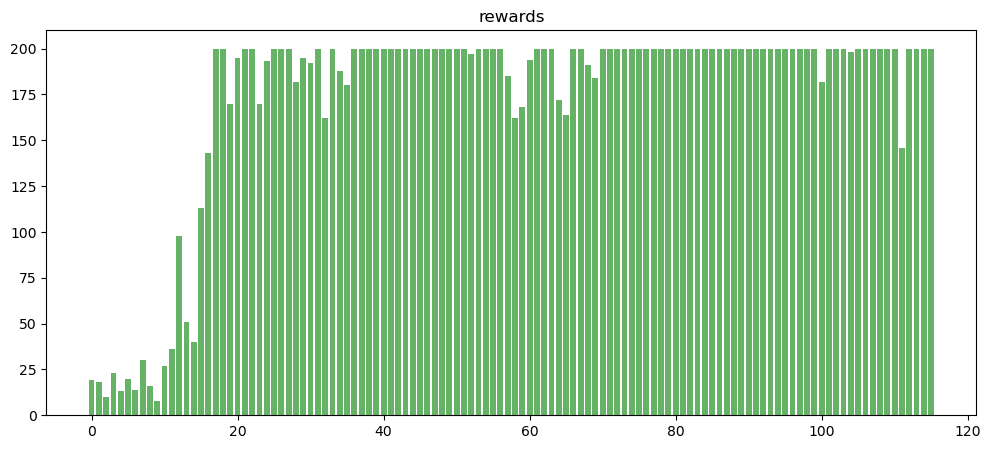

In [6]:
start = time.time()

memory = ExperienceReplay(replay_mem_size) 
qnet_agent = QNet_Agent()
steps_total = []
frames_total = 0

for i_episode in tqdm(range(num_episodes)):
    if solved:
        break
    state = env.reset()
    
    step = 0
    
    while True:
        step += 1
        frames_total += 1
        
        epsilon = calculate_epsilon(frames_total)
        
        action = qnet_agent.select_action(state, epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state, reward, done)
        qnet_agent.optimize()
        
        state = new_state
        if done:
            steps_total.append(step)
            mean_reward_100 = np.mean(steps_total[-100:])
            if mean_reward_100 > score_to_solve:
                print(f'Solved after {i_episode} episodes')
                solved_after = step
                solved = True
            break
    
    if i_episode % 100 == 0:
        print(f'\n**** Episode {i_episode}****')
        print(f'\nAverage Reward - last 10: {np.mean(steps_total[-10:])}')
        print(f'\nAverage Reward - last 100: {np.mean(steps_total[-100:])}')
        print(f'\nAverage Reward - total: {np.mean(steps_total)}')
        print(f'\nEpsilon: {epsilon:.2f};')
        print(f'\nElapsed time: {time.time() - start:.2f} seconds;')


print(f'\n**** FINAL****')
print(f'Average reward {np.mean(steps_total)}')
print(f'Average reward (last 100 episodes) {np.mean(steps_total[-100:])}')
if solved:
    print(f'Solved after {solved_after}')

fig, axis = plt.subplots(1, 1, figsize=(12, 5))
axis.bar(np.arange(len(steps_total)), steps_total, alpha=0.6, color='green')
axis.set_title('rewards')
# axis[1].bar(np.arange(len(agent_1.steps)), agent_1.steps, alpha=0.6, color='red')
# axis[1].set_title('steps')
# plt.plot(steps_total, color='red')